# Supervised sentiment: dense feature representations and neural networks

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Distributed representations as features](#Distributed-representations-as-features)
  1. [GloVe inputs](#GloVe-inputs)
  1. [IMDB representations](#IMDB-representations)
  1. [Remarks on this approach](#Remarks-on-this-approach)
1. [RNN classifiers](#RNN-classifiers)
  1. [RNN dataset preparation](#RNN-dataset-preparation)
  1. [Vocabulary for the embedding](#Vocabulary-for-the-embedding)
  1. [Pure NumPy RNN implementation](#Pure-NumPy-RNN-implementation)
  1. [PyTorch implementation](#PyTorch-implementation) 
  1. [Pretrained embeddings](#Pretrained-embeddings)
1. [Tree-structured neural networks](#Tree-structured-neural-networks)
  1. [TreeNN dataset preparation](#TreeNN-dataset-preparation)
  1. [Pure NumPy TreeNN implementation](#Pure-NumPy-TreeNN-implementation)
  1. [PyTorch TreeNN implementation](#PyTorch-TreeNN-implementation)
  1. [Subtree supervision](#Subtree-supervision)

## Overview

This notebook defines and explores __recurrent neural network (RNN) classifiers__ and __tree-structured neural network (TreeNN) classifiers__ for the Stanford Sentiment Treebank. 

These approaches make their predictions based on comprehensive representations of the examples: 

* For the RNN, each word is modeled, as are its sequential relationships to the other words.
* For the TreeNN, the entire parsed structure of the sentence is modeled.

Both models contrast with the ones explored in [the previous notebook](sst_02_hand_built_features.ipynb), which make predictions based on more partial, potentially idiosyncratic information extracted from the examples.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [2]:
from collections import Counter
import numpy as np
import os
import pandas as pd
from np_rnn_classifier import RNNClassifier
from np_tree_nn import TreeNN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst
import vsm
import utils

In [3]:
# Set all the random seeds for reproducibility. Only the
# system and torch seeds are relevant for this notebook.

utils.fix_random_seeds()

In [4]:
DATE_HOME = 'data'

GLOVE_HOME = os.path.join(DATE_HOME, 'glove.6B')

VSMDATA_HOME = os.path.join(DATE_HOME, 'vsmdata')

SST_HOME = os.path.join(DATE_HOME, 'trees')

## Distributed representations as features

As a first step in the direction of neural networks for sentiment, we can connect with our previous unit on distributed representations. Arguably, more than any specific model architecture, this is the major innovation of deep learning: __rather than designing feature functions by hand, we use dense, distributed representations, often derived from unsupervised models__.

<img src="fig/distreps-as-features.png" width=500 alt="distreps-as-features.png" />

Our model will just be `LogisticRegression`, and we'll continue with the experiment framework from the previous notebook. Here is `fit_maxent_classifier` again:

In [5]:
def fit_maxent_classifier(X, y):   
    mod = LogisticRegression(
        fit_intercept=True, 
        solver='liblinear', 
        multi_class='auto')
    mod.fit(X, y)
    return mod

### GloVe inputs

To illustrate this process, we'll use the general purpose GloVe representations released by the GloVe team, at 300d:

In [6]:
glove_lookup = utils.glove2dict(
    os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))

In [7]:
def vsm_leaves_phi(tree, lookup, np_func=np.sum):
    """Represent `tree` as a combination of the vector of its words.
    
    Parameters
    ----------
    tree : nltk.Tree   
    lookup : dict
        From words to vectors.
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that 
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a 
        fixed length, no matter what the size of the tree is.
    
    Returns
    -------
    np.array, dimension `X.shape[1]`
            
    """      
    allvecs = np.array([lookup[w] for w in tree.leaves() if w in lookup])    
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:       
        feats = np_func(allvecs, axis=0)      
    return feats

In [8]:
def glove_leaves_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, glove_lookup, np_func=np_func)

In [9]:
_ = sst.experiment(
    SST_HOME,
    glove_leaves_phi,
    fit_maxent_classifier,
    class_func=sst.ternary_class_func,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

              precision    recall  f1-score   support

    negative      0.626     0.738     0.677       996
     neutral      0.278     0.073     0.116       479
    positive      0.670     0.778     0.720      1089

    accuracy                          0.631      2564
   macro avg      0.525     0.530     0.504      2564
weighted avg      0.580     0.631     0.591      2564



### IMDB representations

Our IMDB VSMs seems pretty well-attuned to the Stanford Sentiment Treebank, so we might think that they can do even better than the general-purpose GloVe inputs. Here are two quick assessments of that idea:

In [10]:
imdb20 = pd.read_csv(
    os.path.join(VSMDATA_HOME, 'imdb_window20-flat.csv.gz'), index_col=0)

In [11]:
imdb20_ppmi = vsm.pmi(imdb20, positive=False) 

In [12]:
imdb20_ppmi_svd = vsm.lsa(imdb20_ppmi, k=50) 

In [13]:
imdb_lookup = dict(zip(imdb20_ppmi_svd.index, imdb20_ppmi_svd.values))

In [14]:
def imdb_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, imdb_lookup, np_func=np_func)

In [15]:
_ = sst.experiment(
    SST_HOME,
    imdb_phi,
    fit_maxent_classifier,
    class_func=sst.ternary_class_func,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

              precision    recall  f1-score   support

    negative      0.568     0.713     0.632       977
     neutral      0.273     0.006     0.012       497
    positive      0.627     0.763     0.689      1090

    accuracy                          0.598      2564
   macro avg      0.489     0.494     0.444      2564
weighted avg      0.536     0.598     0.536      2564



### Remarks on this approach

* Recall that our `unigrams_phi` created feature representations with over 16K dimensions and got about 0.77.

* The above models have only 50 dimensions and come close in terms of performance. In many ways, it's striking that we can get a model that is competitive with so few dimensions.

* The promise of the Mittens model of [Dingwall and Potts 2018](https://arxiv.org/abs/1803.09901) is that we can use GloVe itself to update the general purpose information in the 'glove.6B' vectors with specialized information from one of these IMDB count matrices. That might be worth trying; the `mittens` package already implements this!

* That said, just summing up all the word representations is pretty unappealing linguistically. There's no doubt that we're losing a lot of valuable information in doing this. The models we turn to now can be seen as addressing this shortcoming while retaining the insight that our distributed representations are valuable for this task.

## RNN classifiers

A recurrent neural network (RNN) is any deep learning model that process its inputs sequentially. There are many variations on this theme. The one that we use here is an __RNN classifier__.

<img src="fig/rnn_classifier.png" width=800 />

For a sequence of length $n$:

$$\begin{align*}
h_{t} &= \tanh(x_{t}W_{xh} + h_{t-1}W_{hh}) \\
y     &= \textbf{softmax}(h_{n}W_{hy} + b)
\end{align*}$$

where $1 \leqslant t \leqslant n$. As indicated in the above diagram, the sequence of hidden states is padded with an initial state $h_{0}$ In our implementations, this is always an all $0$ vector, but it can be initialized in more sophisticated ways (some of which we will explore in our unit on natural language inference).

This is a potential gain over our sum-the-word-vectors baseline, in that it processes each word independently, and in the context of those that came before it. Thus, not only is this sensitive to word order, but the hidden representation give us the potential to encode how the preceding context for a word affects its interpretation.

The downside of this, of course, is that this model is much more difficult to set up and optimize. Let's dive into those details.

### RNN dataset preparation

SST contains trees, but the RNN processes just the sequence of leaf nodes. The function `sst.build_rnn_dataset` creates datasets in this format:

In [16]:
X_rnn_train, y_rnn_train = sst.build_rnn_dataset(
    SST_HOME, sst.train_reader, class_func=sst.ternary_class_func)

Each member of `X_rnn_train` is a list of lists of words. Here's a look at the start of the first:

In [17]:
X_rnn_train[0][: 6]

['The', 'Rock', 'is', 'destined', 'to', 'be']

Because this is a classifier, `y_rnn_train` is just a list of labels, one per example:

In [18]:
y_rnn_train[0]

'positive'

For experiments, let's build a `dev` dataset as well:

In [19]:
X_rnn_dev, y_rnn_dev = sst.build_rnn_dataset(
    SST_HOME, sst.dev_reader, class_func=sst.ternary_class_func)

### Vocabulary for the embedding

The first delicate issue we need to address is the vocabulary for our model:

* As indicated in the figure above, the first thing we do when processing an example is look up the words in an embedding (a VSM), which has to have a fixed dimensionality. 

* We can use our training data to specify the vocabulary for this embedding; at prediction time, though, we will inevitably encounter words we haven't seen before. 

* The convention we adopt here is to map them to an `$UNK` token that is in our pre-specified vocabulary.

* At the same time, we might want to collapse infrequent tokens into `$UNK` to make optimization easier.

In `utils`, the function `get_vocab` implements these strategies. Now we can extract the training vocab and use it for the model embedding, secure in the knowledge that we will be able to process tokens outside of this set (by mapping them to `$UNK`).

In [20]:
sst_full_train_vocab = utils.get_vocab(X_rnn_train)

In [21]:
print("sst_full_train_vocab has {:,} items".format(len(sst_full_train_vocab)))

sst_full_train_vocab has 18,279 items


This frankly seems too big relative to our dataset size. Let's restrict to just 10000 words:

In [22]:
sst_train_vocab = utils.get_vocab(X_rnn_train, n_words=10000)

### Pure NumPy RNN implementation

The first implementation we'll look at is a pure NumPy implementation of exactly the model depicted above. This implementation is a bit slow and might not be all that effective, but it is useful to have available in case one really wants to inspect the details of how these models process examples.

In [23]:
rnn = RNNClassifier(
    sst_train_vocab,
    embedding=None,  # Will be randomly initialized.
    embed_dim=50,
    hidden_dim=50,
    max_iter=50,   
    eta=0.05)    

In [24]:
%time _ = rnn.fit(X_rnn_train, y_rnn_train)

Finished epoch 50 of 50; error is 1.7538992936746153

CPU times: user 4min 20s, sys: 483 ms, total: 4min 21s
Wall time: 4min 21s


In [25]:
rnn_dev_predictions = rnn.predict(X_rnn_dev)

In [26]:
print(classification_report(y_rnn_dev, rnn_dev_predictions))

              precision    recall  f1-score   support

    negative       0.40      0.43      0.42       428
     neutral       0.21      0.17      0.19       229
    positive       0.39      0.40      0.39       444

    accuracy                           0.37      1101
   macro avg       0.34      0.34      0.33      1101
weighted avg       0.36      0.37      0.36      1101



### PyTorch implementation

The included PyTorch implementation is much faster and more configurable.

In [27]:
torch_rnn = TorchRNNClassifier(
    sst_train_vocab,
    embed_dim=50,
    hidden_dim=50,
    max_iter=50,
    eta=0.05) 

In [28]:
%time _ = torch_rnn.fit(X_rnn_train, y_rnn_train)

Finished epoch 50 of 50; error is 0.45758889243006706

CPU times: user 16min 28s, sys: 3min 9s, total: 19min 38s
Wall time: 3min 46s


In [29]:
torch_rnn_dev_predictions = torch_rnn.predict(X_rnn_dev)

In [30]:
print(classification_report(y_rnn_dev, torch_rnn_dev_predictions))

              precision    recall  f1-score   support

    negative       0.55      0.62      0.59       428
     neutral       0.23      0.18      0.20       229
    positive       0.62      0.62      0.62       444

    accuracy                           0.53      1101
   macro avg       0.47      0.47      0.47      1101
weighted avg       0.51      0.53      0.52      1101



### Pretrained embeddings

With `embedding=None`, `RNNClassifier`, `TorchRNNClassifier` and `TfRNNClassifier` create random embeddings in which the values are drawn from a uniform distribution with bounds `[-1, 1)`. You can also pass in an embedding, as long as you make sure it has the right vocabulary. The utility `utils.create_pretrained_embedding` will help with that:

In [31]:
glove_embedding, sst_glove_vocab = utils.create_pretrained_embedding(
    glove_lookup, sst_train_vocab)

Here's an illustration using `TorchRNNClassifier`:

In [32]:
torch_rnn_glove = TorchRNNClassifier(
    sst_glove_vocab,
    embedding=glove_embedding,
    hidden_dim=50,
    max_iter=50,
    eta=0.05) 

In [33]:
%time _ = torch_rnn_glove.fit(X_rnn_train, y_rnn_train)

Finished epoch 50 of 50; error is 2.6605194807052612

CPU times: user 14min 34s, sys: 3min 31s, total: 18min 6s
Wall time: 3min 19s


In [34]:
torch_rnn_imdb_dev_predictions = torch_rnn_glove.predict(X_rnn_dev)

In [35]:
print(classification_report(y_rnn_dev, torch_rnn_imdb_dev_predictions))

              precision    recall  f1-score   support

    negative       0.60      0.56      0.58       428
     neutral       0.27      0.21      0.24       229
    positive       0.61      0.72      0.66       444

    accuracy                           0.55      1101
   macro avg       0.49      0.50      0.49      1101
weighted avg       0.54      0.55      0.54      1101



## Tree-structured neural networks

Tree-structured neural networks (TreeNNs) are close relatives of RNN classifiers. (If you tilt your head, you can see the above sequence model as a kind of tree.) The TreeNNs we explore here are the simplest possible and actually have many fewer parameters than RNNs. Here's a summary:

<img src="fig/tree_nn.png" width=800 />

The crucial property of these networks is the way they employ recursion: the representation of a parent node $p$ has the same dimensionality as the word representations, allowing seamless repeated application of the central combination function:

$$p = \tanh([x_{L};x_{R}]W_{wh} + b)$$

Here, $[x_{L};x_{R}]$ is the concatenation of the left and right child representations, and $p$ is the resulting parent node, which can then be a child node in a higher subtree.

When we reach the root node $h_{r}$ of the tree, we apply a softmax classifier using that top node's representation:

$$y = \textbf{softmax}(h_{r}W_{hy} + b)$$

### TreeNN dataset preparation

This is the only model under consideration here that makes use of the tree structures in the SST:

In [36]:
X_tree_train, _  = sst.build_tree_dataset(SST_HOME, sst.train_reader)

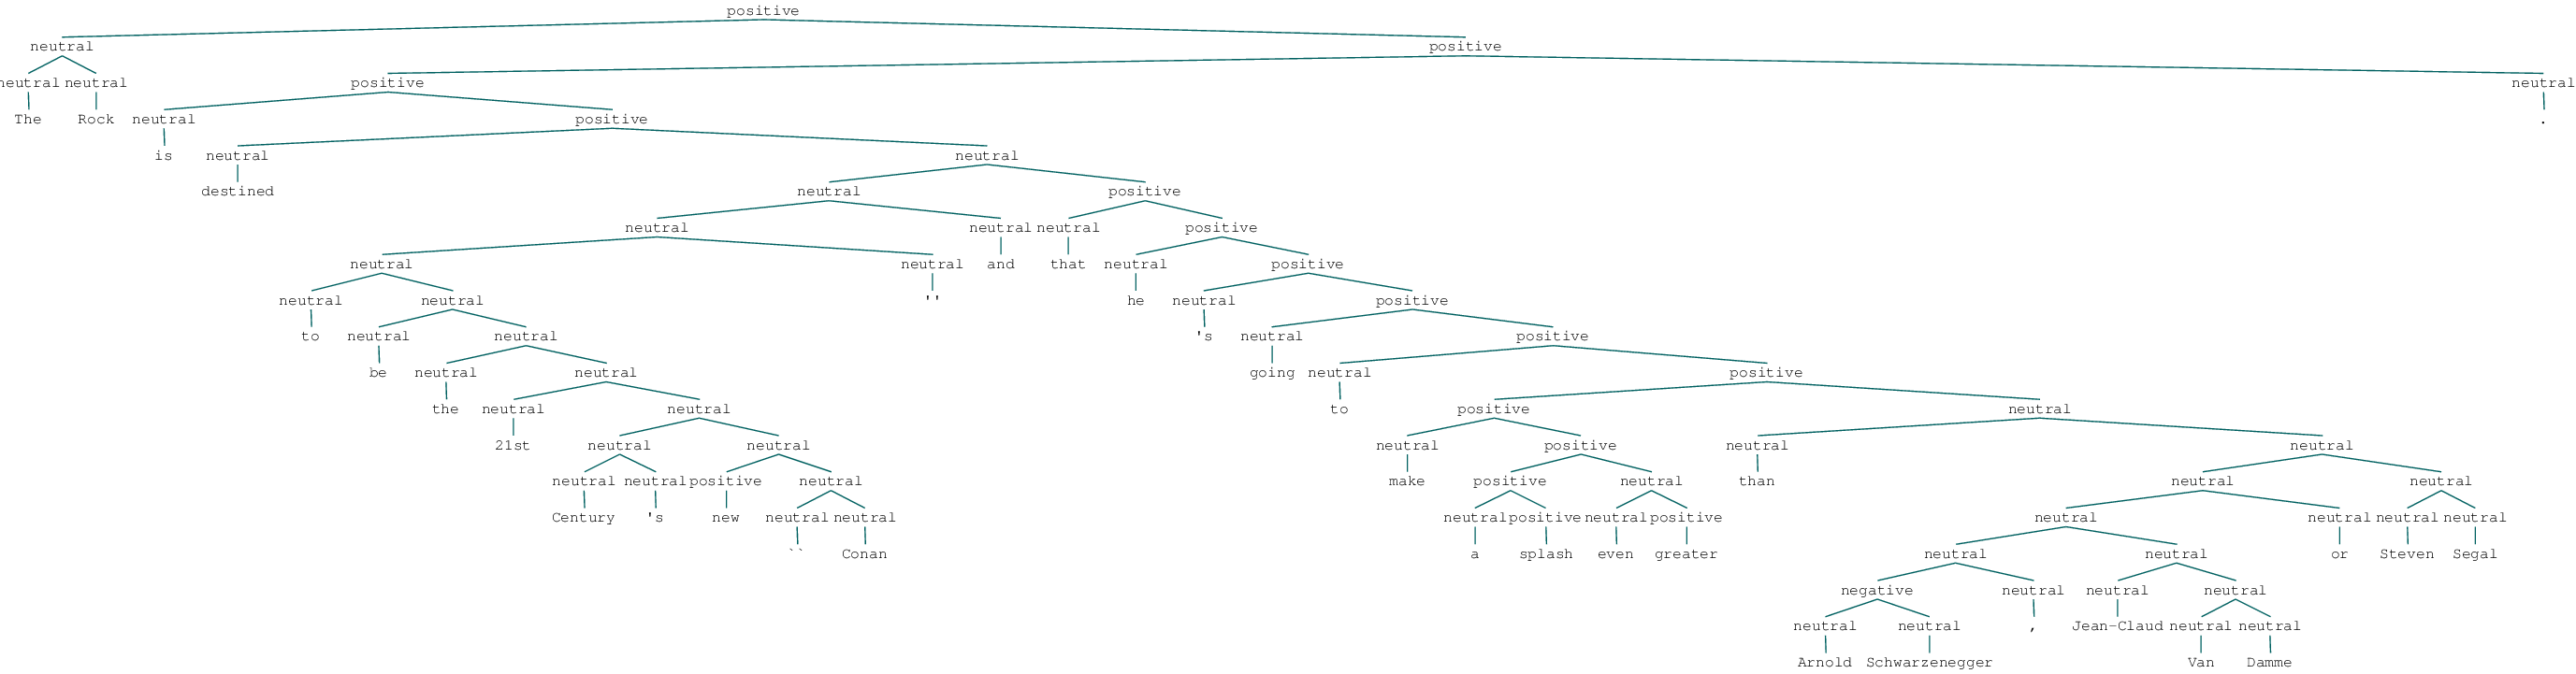

In [37]:
X_tree_train[0]

In [38]:
X_tree_dev, y_tree_dev = sst.build_tree_dataset(
    SST_HOME, sst.dev_reader, class_func=sst.ternary_class_func)

### Pure NumPy TreeNN implementation

`TreeNN` is a pure NumPy implementation of this model. It should be regarded as a baseline for models of this form. The original SST paper includes evaluations of a wide range of models in this family.

In [39]:
tree_nn_glove = TreeNN(
    sst_glove_vocab,
    embedding=glove_embedding,
    embed_dim=None,  # Ignored when embedding is not `None`
    max_iter=10,
    eta=0.05) 

The `fit` method to this model is unusual in that it takes only a list of trees as its argument. It is assumed that the label on the root node of each tree (`tree.label()`) is its class label.

In [40]:
%time _ = tree_nn_glove.fit(X_tree_train)

Finished epoch 10 of 10; error is 9.096302273909426

CPU times: user 25min 37s, sys: 3min 14s, total: 28min 52s
Wall time: 7min 18s


Important: if you wish to cross-validate this model using scikit-learn methods, then you'll need to give the labels as a separate argument, as in 

```
y_tree_train = [t.label() for t in X_tree_train]
tree_nn_glove.fit(X_tree_train, y_tree_train)
```

In [41]:
tree_glove_dev_predictions = tree_nn_glove.predict(X_tree_dev)

In [42]:
print(classification_report(y_tree_dev, tree_glove_dev_predictions))

              precision    recall  f1-score   support

    negative       0.34      0.19      0.24       428
     neutral       0.20      0.45      0.28       229
    positive       0.39      0.31      0.34       444

    accuracy                           0.29      1101
   macro avg       0.31      0.32      0.29      1101
weighted avg       0.33      0.29      0.29      1101



### PyTorch TreeNN implementation

In [43]:
torch_tree_nn_glove = TorchTreeNN(
    sst_glove_vocab,
    embedding=glove_embedding,
    embed_dim=50,
    max_iter=10,
    eta=0.05)

In [44]:
%time _ = torch_tree_nn_glove.fit(X_tree_train)

Finished epoch 10 of 10; error is 13.258677088631677

CPU times: user 40min 35s, sys: 9min 28s, total: 50min 4s
Wall time: 7min 31s


As with `TreeNN` above, you have the option of specifying the labels separately, and this is required if you are cross-validating the model using scikit-learn methods.

In [45]:
torch_tree_glove_dev_predictions = torch_tree_nn_glove.predict(X_tree_dev)

In [46]:
print(classification_report(y_tree_dev, torch_tree_glove_dev_predictions))

              precision    recall  f1-score   support

    negative       0.39      0.42      0.40       428
     neutral       0.20      0.47      0.28       229
    positive       0.38      0.08      0.13       444

    accuracy                           0.29      1101
   macro avg       0.32      0.32      0.27      1101
weighted avg       0.35      0.29      0.27      1101



### Subtree supervision

We've so far ignored one of the most exciting aspects of the SST: it has sentiment labels on every constituent from the root down to the lexical nodes. 

It is fairly easy to extend `TorchTreeNN` to learn from these additional labels. The key change is that the recursive interpretation function has to gather all of the node representations and their true labels and pass these to the loss function:

<img src="fig/tree_nn_subtrees.png" width=600 />